In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import theano

import pymc3 as pm

%matplotlib inline

In [0]:
%%capture
%%bash
mkdir data/
wget -P ./data/ https://github.com/sachinruk/bayes_school/raw/master/data/all_stocks_5yr.csv.zip 

The data was downloaded from https://www.kaggle.com/camnugent/sandp500

In [3]:
df = pd.read_csv('./data/all_stocks_5yr.csv.zip', compression='zip')
df.head()

,Date,Open,High,Low,Close,Volume,Name
0,2012-08-13,92.29,92.59,91.74,92.40,2075391.0,MMM
1,2012-08-14,92.36,92.50,92.01,92.30,1843476.0,MMM
2,2012-08-15,92.00,92.74,91.94,92.54,1983395.0,MMM
3,2012-08-16,92.75,93.87,92.21,93.74,3395145.0,MMM
4,2012-08-17,93.93,94.30,93.59,94.24,3069513.0,MMM


In [4]:
stocks = ['MSFT', 'AAPL', 'GOOG', 'NEM', 'ALB']
df_stocks = df.loc[df.Name.isin(stocks), ['Date', 'Close', 'Name']]
df_stocks.shape

(6290, 3)

In [5]:
df_stocks = df_stocks.pivot(index='Date', columns='Name', values='Close')
df_stocks.head()

Name,AAPL,ALB,GOOG,MSFT,NEM
Date,,,,,
2012-08-13,90.00,61.07,329.67,30.39,46.92
2012-08-14,90.24,60.44,334.00,30.13,46.34
2012-08-15,90.12,60.87,333.44,30.20,46.63
2012-08-16,90.91,61.20,336.10,30.78,47.59
2012-08-17,92.59,61.31,338.23,30.90,47.16


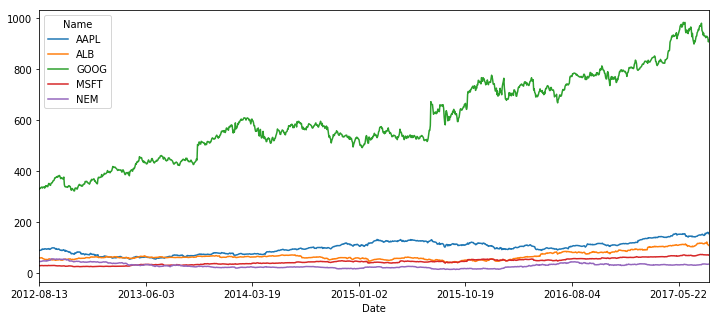

In [6]:
df_stocks.plot(figsize=(12, 5))
plt.show()

In [0]:
y_mean = df_stocks.mean()
y_std = df_stocks.std()
df_stocks = (df_stocks - y_mean) / y_std

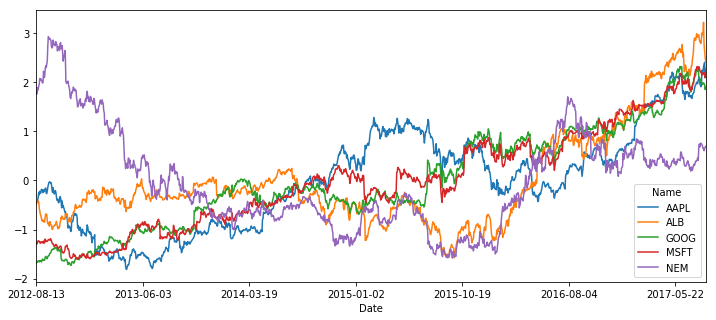

In [8]:
df_stocks.plot(figsize=(12, 5))
plt.show()

## Generating Synthetic data

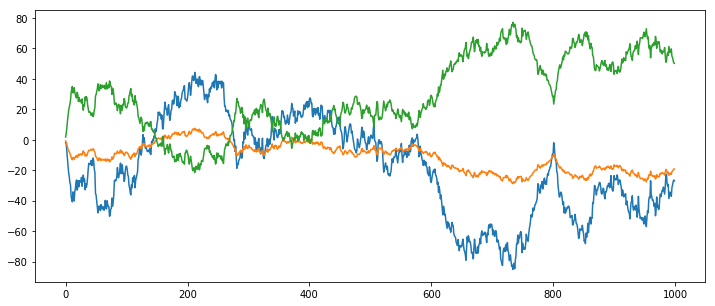

In [9]:
N = 1000
D = 3

Q = np.random.randn(D, D)
Σ = Q.dot(Q.T)

e = np.random.randn(N, D)
e = e.dot(Σ)

y2 = np.cumsum(e, axis=0)
plt.figure(figsize=(12, 5))
plt.plot(y2)
plt.show()

## Inference Process

In [0]:
def inference(y, t, window=365, n_samples=100):
    N, D = y.shape

    t_section = np.int64(np.arange(len(y)))//window
    k = t_section.max()+1

    t_t = theano.shared(np.repeat(t[:,np.newaxis], D, axis=1))
    y_t = theano.shared(y)
    t_section_t = theano.shared(t_section)

    with pm.Model() as model:
        sd_α = pm.HalfCauchy.dist(beta=0.5)
        packed_L_α = pm.LKJCholeskyCov('packed_L_α', n=D, eta=2., sd_dist=sd_α)
        L_α = pm.expand_packed_triangular(D, packed_L_α)
        Σ_α = pm.Deterministic('Σ_α', L_α.dot(L_α.T))

#         μ_β = pm.Bound(pm.Normal, lower=0, upper=1)('μ_β', sd=0.5, shape=D)
        sd_β = pm.HalfCauchy.dist(beta=0.5)
        packed_L_β = pm.LKJCholeskyCov('packed_L_β', n=D, eta=2., sd_dist=sd_β)
        L_β = pm.expand_packed_triangular(D, packed_L_β)
        Σ_β = pm.Deterministic('Σ_β', L_β.dot(L_β.T))

        α = pm.MvGaussianRandomWalk('alpha', shape=(k+1, D), cov=Σ_α)
        β = pm.MvGaussianRandomWalk('beta', shape=(k+1, D),  cov=Σ_β)#mu=μ_β,
        alpha_r = α[t_section_t]
        beta_r = β[t_section_t]
        regression = alpha_r+beta_r*t_t

        sd = pm.Uniform('sd', 0, 1)
        likelihood = pm.Normal('y', mu=regression, sd=sd, observed=y_t)
        trace = pm.sample(n_samples)

    return trace, t_section

In [0]:
t = np.arange(len(df_stocks))
t = (t-t.mean())/t.std()

In [13]:
trace, t_section = inference(df_stocks.values, t, n_samples=500)

/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]
/usr/local/lib/python3.6/dist-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be inter

In [0]:
a_mean = trace['alpha'][-1000:].mean(axis=0)
b_mean = trace['beta'][-1000:].mean(axis=0)

y_pred = a_mean[t_section] + b_mean[t_section]*t[:,None]

# Un-normalise the data
y_pred = y_pred*y_std[None,:] + y_mean[None,:]
y = df_stocks.values*y_std[None,:] + y_mean[None,:]

In [0]:
dates = np.array([np.datetime64(d) for d in df_stocks.index])
stocks = df_stocks.columns.values

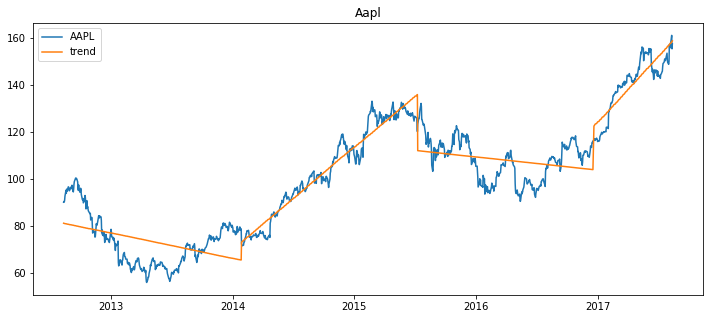

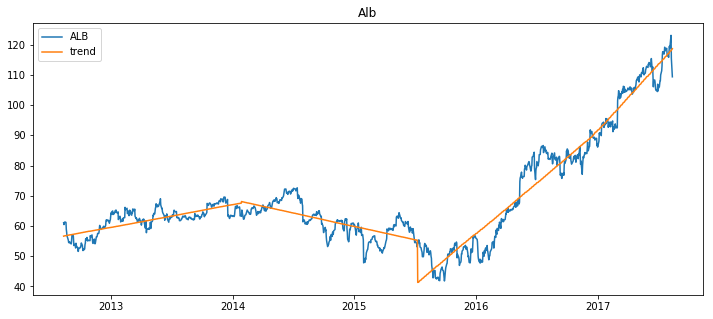

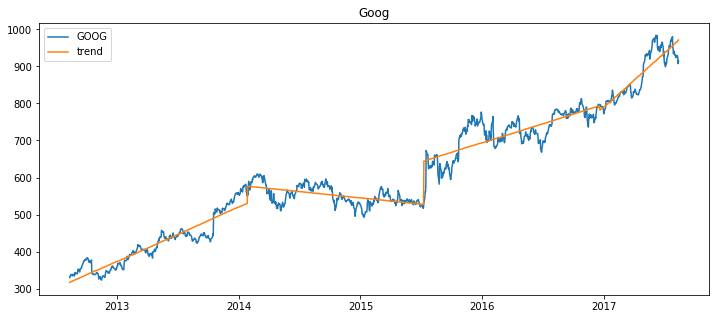

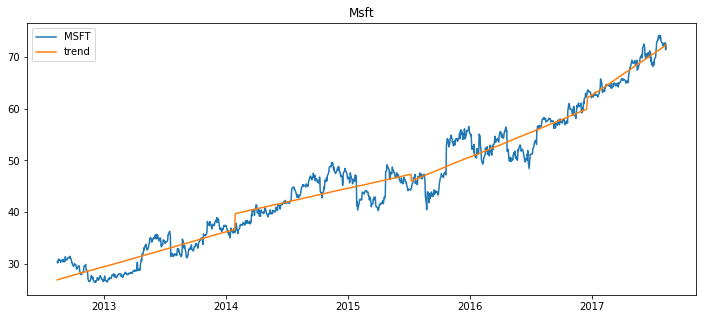

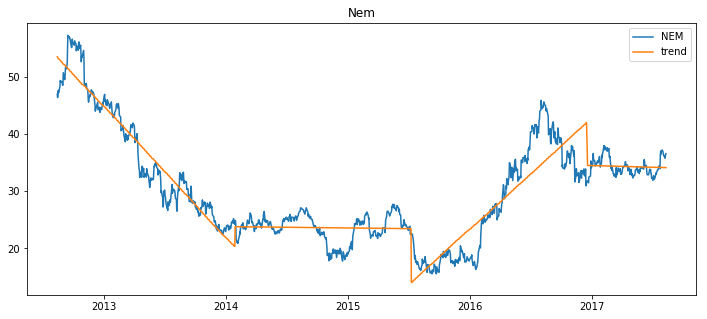

In [16]:
for i, stock in enumerate(stocks):
    plt.figure(figsize=(12,5))
    plt.plot(dates, y[:, i], label=stock)
    plt.plot(dates, y_pred[:, i], label="trend")
    plt.legend()
    plt.title(stock.capitalize())
    plt.show()

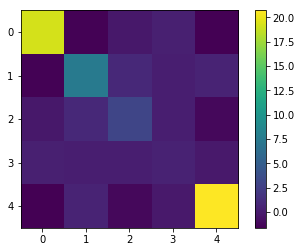

In [17]:
plt.imshow(trace['Σ_β'].mean(axis=0))
plt.colorbar()
plt.show()

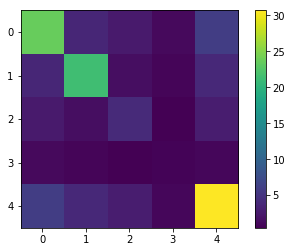

In [18]:
plt.imshow(trace['Σ_β'].std(axis=0))
plt.colorbar()
plt.show()

## Correlation

In [19]:
stocks

array(['AAPL', 'ALB', 'GOOG', 'MSFT', 'NEM'], dtype=object)

In [0]:
trace_sigma2 = np.zeros_like(trace['Σ_β'])
for i,t in enumerate(trace['Σ_β']):
    t_diag = np.sqrt(t.diagonal())
    trace_sigma2[i] = (t/t_diag[:,None])/t_diag[None,:]

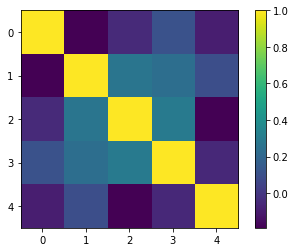

In [21]:
plt.imshow(trace_sigma2.mean(axis=0))
plt.colorbar()
plt.show()

NEM and ALB have a correlation of 0.5 (as expected).

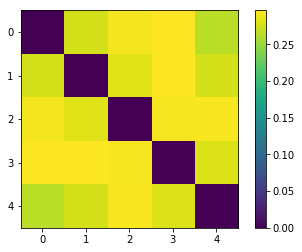

In [22]:
plt.imshow(trace_sigma2.std(axis=0))
plt.colorbar()
plt.show()